# Data cleaning and sentiment <a class="anchor" id="top"></a>

## TOC:
* [Filter, clean and sentiment functions](#bullet1)
    - [Different methods data filtering and sentiment calculations](#sub-bullet1.1)
* [The correct sentiment measure](#bullet2)
    - [Sentiment measure correlation](#sub-bullet2.1)
* [Looping all stock csv's](#bullet3)
* [ToDo](#ToDo)


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# import statsmodels.formula.api as sm


In [6]:
path = r"E:\Users\Christiaan\Large_Files\Thesis\Twitter\merged\NFLX.csv"
df = pd.read_csv(path)

## Filter, clean and sentiment functions <a class="anchor" id="bullet1"></a>

The code below contains functions which are used on the dataframe to:
- Perform data cleaning
- Filter the data
- Calculate the sentiment

The **<u>data filtering</u>** will be done using 2 different methods.
- Method 1: Filters observations with based on the number of tickers which are mentioned in the Tweet. If this number differs from 1 ticker mentioned, the post is filtered. The second rule of this filter method is that the 1 ticker which is mentioned, is that this ticker is the ticker of the company of which the sentiment is being calculated.
- Method 2: This method is more lenient and allows for multiple tickers to be mentioned, as long as the company ticker which is being investigated is also mentioned.

The **<u>sentiment calculations</u>** will also be done using 2 different methods using the [cjhutto vaderSentiment library](https://github.com/cjhutto/vaderSentiment).
- Method 1: Uses the original cjhutto vaderSentiment library. 
- Method 2: Uses the original cjhutto vaderSentiment library, however some word-sentiment pairs are added to finetune the VADER model for financial texts. 

In [8]:
#   ---------------------------   Data cleaning   ---------------------------
def clean_text(text):
    # Remove twitter Return handles (RT @xxx:)
    text = re.sub("RT @[\w]*:", "", text)

    # Remove twitter handles (@xxx)
    text = re.sub("@[\w]*", "", text)

    # Remove URL links (httpxxx)
    url_matcher = "((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*"
    text = re.sub(url_matcher, "", text)
    
    # Remove any multiple white spaces, tabs or newlines
    text = re.sub('\s+',' ', text)
    
    #remove “”
    text = re.sub("“|”", "", text)
    
    return text

#   ---------------------------   Data filtering   ---------------------------

# Method 1 filters the posts based on only 1 rule, which is that the ticker of the company of ...
# ... which the sentiment is being calculated is present.
def filter_data_1(post, ticker):
    # Filter out posts that do not mention the company ticker.
    if bool(re.search(fr"\${ticker}", post, re.IGNORECASE)):
        return True
    else:
        return False 

# Method 2 filters the posts based on the rule that exactly 1 ticker is mentioned and ...
# ... that this ticker is the ticker of the company of which the sentiment is being calculated   
def filter_data_2(post, ticker):
    # Count the number of tickers in the post
    matches = re.findall(r"\$[a-zA-Z]+", post)
    count = len(matches)
    
    # Filter out posts with more or less than 1 ticker, and check whether this 1 ticker is the company ticker.
    if count == 1 and bool(re.search(fr"\${ticker}", post, re.IGNORECASE)):
        return True
    else:
        return False




In [9]:
# Adding word-sentiment pairs to the cjhutto vaderSentiment library.
new_words = {}

# Adding custom postive words
positive_words = {
    'buy': 2.0,
    'buying': 2.0,
    'bullish': 2.0,
    'long': 1.0,
    'call': 1.0,
    'calls': 1.0,
    'rocket': 3.0,        # Added for 'rocket' emoji 🚀
    'increasing': 2.0,     # Added for 'chart increasing' emoji 📈
    'to the moon': 2.5,
    "undervalued": 2.0
}
# Adding custom negative words
negative_words = {
    'decreasing': -2.0,   # Added for 'chart increasing' emoji 📉
    'sell': -2.0,
    'selling': -2.0,
    'bearish': -2.0,
    'put': -1,
    'puts': -1,
    'short': -1.0,
    'shorting': -1.5,
    "overvalued": -2.0,
    'expensive': -1.5
}

# Adding positive and negative words to new_worddictionary
new_words.update(positive_words)
new_words.update(negative_words)

In [10]:
#   ---------------------------   Sentiment   ---------------------------
# Creating SIA, which uses standard words.
SIA = SentimentIntensityAnalyzer()

def calc_sentiment_1(text, sent_type):
    result = SIA.polarity_scores(text)
    return result[sent_type]

# Creating SIA2 to add custom words.
SIA2 = SentimentIntensityAnalyzer()
SIA2.lexicon.update(new_words)

def calc_sentiment_2(text, sent_type):
    result = SIA2.polarity_scores(text)
    return result[sent_type]

**Merged**

Next, all functions above are put into one function which can be applied to a dataframe. The goal is to prepare all the data which is necessary for the sentiment analysis later on.

In [11]:
import time

def clean_data(df, ticker):
    start_time = time.time()
    # Drop all non English Tweets and any unnnamed columns
    df = df[df['lang'] == 'en']
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    
    # Create some datetime items
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['date'] = df['created_at'].dt.date
    df['hour'] = df['created_at'].dt.hour
#     df['test'] = df['text'].apply(filter_data_1, ticker=ticker)
    
    #   ---------------------------   Data cleaning   ---------------------------
    # Clean text
    df['text'] = df['text'].apply(clean_text)
    print(f"[{ticker}] Done cleaning after --- %s seconds ---" % (time.time() - start_time))
    
    # Drop duplicate tweets based on cleaned text (sometimes Tweets include the same text but different links for example)
    df = df.drop_duplicates(subset=['author_id', 'text'], keep=False)
    
    #   ---------------------------   Data filter   ---------------------------
    # Filter dataframe using both filter 1 and 2 (read above what they mean)
    df['filter_1'] = df['text'].apply(filter_data_1, ticker=ticker)
    df['filter_2'] = df['text'].apply(filter_data_2, ticker=ticker)
    
    print(f"[{ticker}] Done filtering after --- %s seconds ---" % (time.time() - start_time))
    
    #   ---------------------------   Sentiment   ---------------------------
    # Calculate sentiment scores
    df[f'compound_sent_1'] = df['text'].astype(str).apply(calc_sentiment_1, sent_type='compound')
    df[f'compound_sent_2'] = df['text'].astype(str).apply(calc_sentiment_2, sent_type='compound')
    
    print(f"[{ticker}] Done calculating sentiment after --- %s seconds ---" % (time.time() - start_time))
    
    """Converting this to pos, neg or neu sentiment
    - positive sentiment: compound score >= 0.05
    - neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
    - negative sentiment: compound score <= -0.05
    """
    
    # Check if sentiment corresponds to pos, neg or neu sentiment for compound_sent_1
    df['s1_pos'] = np.where(df['compound_sent_1'] >= 0.05, 1, 0)
    df['s1_neg'] = np.where(df['compound_sent_1'] <= -0.05, 1, 0)

    # Check if sentiment corresponds to pos, neg or neu sentiment for compound_sent_2
    df['s2_pos'] = np.where(df['compound_sent_2'] >= 0.05, 1, 0)
    df['s2_neg'] = np.where(df['compound_sent_2'] <= -0.05, 1, 0)
   
    return df


In [ ]:
ticker = 'NFLX'

filedir = r'E:\Users\Christiaan\Large_Files\Thesis\Twitter\merged'
filename = ticker + '.csv'
path = os.path.join(filedir, filename)

df = pd.read_csv(path)

return_df = clean_data(df, ticker)

In [13]:
ticker = 'NFLX'

filedir = r'C:\Users\Ck0rt\Documents\Large files\School\MSc Finance & Investments\Thesis\twitter\merged'
filename = ticker + '.csv'
path = os.path.join(filedir, filename)

df = pd.read_csv(path)

return_df = clean_data(df, ticker)

[NFLX] Done cleaning after --- 21.171192407608032 seconds ---
[NFLX] Done filtering after --- 26.011167287826538 seconds ---
[NFLX] Done calculating sentiment after --- 225.0750846862793 seconds ---


In [15]:
return_df[(return_df['s1_pos']==0) & (return_df['s1_neg']==0)]

,author_id,username,author_followers,author_tweets,author_description,author_location,text,created_at,lang,retweets,...,date,hour,filter_1,filter_2,compound_sent_1,compound_sent_2,s1_pos,s1_neg,s2_pos,s2_neg
5,930803511918411776,ThisLincolnian,734,674690,The Lincolnian Online is an online news organi...,Verenigde Staten,Head-To-Head Survey: Cinedigm $CIDM and Netfli...,2018-04-05 23:24:53+00:00,en,0,...,2018-04-05,23,True,False,0.0,0.0000,0,0,0,0
6,4841202432,TopTickrs,2901,152572,Stock Market Chat | Free to Join at https://t....,United States,FIND YOUR EDGE! EXPLORE STRATEGIES IN OUR GOAL...,2018-04-05 23:24:06+00:00,en,0,...,2018-04-05,23,True,False,0.0,0.0000,0,0,0,0
13,953341415710343168,Tosoption,5,97,"Lawyer, Analyst","Vancouver, British Columbia","Market update earlier in the morning , nowon ...",2018-04-05 23:12:55+00:00,en,1,...,2018-04-05,23,False,False,0.0,0.0000,0,0,0,0
15,700857611810422784,MichaelMOTTCM,80455,16762,Creator of the Reading The Markets and the Lon...,"Garden City, NY","Stock Market Rally Continues, Jobs Report May ...",2018-04-05 23:08:56+00:00,en,0,...,2018-04-05,23,True,False,0.0,0.0000,0,0,0,0
16,2368238768,AccurateTrading,1262,10511,18 year stock and options intraday trader. I t...,USA,4/5/18 Option Positions &amp; Unrealized Profi...,2018-04-05 23:06:10+00:00,en,0,...,2018-04-05,23,True,False,0.0,0.7184,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524698,7841402,thomaspan,508,60328,NaN,Silicon Valey,$NFLX inside day!,2020-08-28 01:22:57+00:00,en,1,...,2020-08-28,1,True,True,0.0,0.0000,0,0,0,0
524700,227755413,leadlagreport,735923,62536,5x Dow & Founders Award Winner. Risk-On/Off $R...,Click link for two weeks free,"With the exception of Netflix, all FAANG stoc...",2020-08-28 01:20:14+00:00,en,9,...,2020-08-28,1,False,False,0.0,0.0000,0,0,0,0
524705,975337043944407040,Finscreener_com,786,18422,"Your world of finance, IG: https://t.co/6cPAsH...",NaN,#SPX $SP500 sector #mega #stocks distribution....,2020-08-28 00:56:29+00:00,en,0,...,2020-08-28,0,True,False,0.0,0.0000,0,0,0,0
524709,1256266861001560066,c_labrinos,376,112199,NFTs | Crypto | Beeig Projects,"New York, USA","Dollars in P/C for $SPY $IWM $QQQ Calls: 31,3...",2020-08-28 00:49:04+00:00,en,1,...,2020-08-28,0,False,False,0.0,0.0000,0,0,0,0


### Different methods data filtering and sentiment calculations <a class="anchor" id="sub-bullet1.1"></a>

As discussed above, two different methods of data filtering and sentiment calculations were performend. This resulted in 4 different combinations of data filters and sentiment calculations

| Method name | Filter | Sentiment measurement type |
| --- | --- | --- |
| f1s1 | Method 1 | Method 1 |
| f1s2 | Method 1 | Method 2 |
| f2s1 | Method 2 | Method 1 |
| f2s2 | Method 2 | Method 2 |




In [18]:
def count_posts(df):
    # Create results_df with [filter_1] [sentiment_1]
    results_df = df[df['filter_1']][['date', 's1_pos', 's1_neg']].groupby('date', as_index=False).sum().rename(columns={"s1_pos": "[f1s1]pos", "s1_neg": "[f1s1]neg"})
    results_df['[f1s1]total'] = results_df['[f1s1]pos'] + results_df['[f1s1]neg']

    # Merge [filter_1] [sentiment_2]
    to_merge_df = df[df['filter_1']][['date', 's2_pos', 's2_neg']].groupby('date', as_index=False).sum().rename(columns={"s2_pos": "[f1s2]pos", "s2_neg": "[f1s2]neg"})
    to_merge_df['[f1s2]total'] = to_merge_df['[f1s2]pos'] + to_merge_df['[f1s2]neg']
    results_df = results_df.merge(to_merge_df, how='left', left_on='date', right_on='date')

    # Merge [filter_2] [sentiment_1]
    to_merge_df = df[df['filter_2']][['date', 's1_pos', 's1_neg']].groupby('date', as_index=False).sum().rename(columns={"s1_pos": "[f2s1]pos", "s1_neg": "[f2s1]neg"})
    to_merge_df['[f2s1]total'] = to_merge_df['[f2s1]pos'] + to_merge_df['[f2s1]neg']
    results_df = results_df.merge(to_merge_df, how='left', left_on='date', right_on='date')

    # Merge [filter_2] [sentiment_2]
    to_merge_df = df[df['filter_2']][['date', 's2_pos', 's2_neg']].groupby('date', as_index=False).sum().rename(columns={"s2_pos": "[f2s2]pos", "s2_neg": "[f2s2]neg"})
    to_merge_df['[f2s2]total'] = to_merge_df['[f2s2]pos'] + to_merge_df['[f2s2]neg']
    results_df = results_df.merge(to_merge_df, how='left', left_on='date', right_on='date')
    
    return results_df
results_df = count_posts(return_df)

,date,[f1s1]pos,[f1s1]neg,[f1s1]total,[f1s2]pos,[f1s2]neg,[f1s2]total,[f2s1]pos,[f2s1]neg,[f2s1]total,[f2s2]pos,[f2s2]neg,[f2s2]total
0,2018-04-01,63,25,88,68,28,96,24,4,28,28,7,35
1,2018-04-02,184,102,286,182,129,311,52,16,68,53,29,82
2,2018-04-03,116,71,187,135,77,212,27,17,44,36,23,59
3,2018-04-04,129,76,205,150,93,243,34,12,46,40,21,61
4,2018-04-05,143,40,183,163,41,204,40,9,49,48,10,58
...,...,...,...,...,...,...,...,...,...,...,...,...,...
880,2020-08-28,196,53,249,218,65,283,48,12,60,56,17,73
881,2020-08-29,80,43,123,109,30,139,20,13,33,26,13,39
882,2020-08-30,78,31,109,102,23,125,25,7,32,27,7,34
883,2020-08-31,358,79,437,407,64,471,135,29,164,162,26,188


Resulting in the following total social media posts with a positive or negative sentiment.

---
<div>
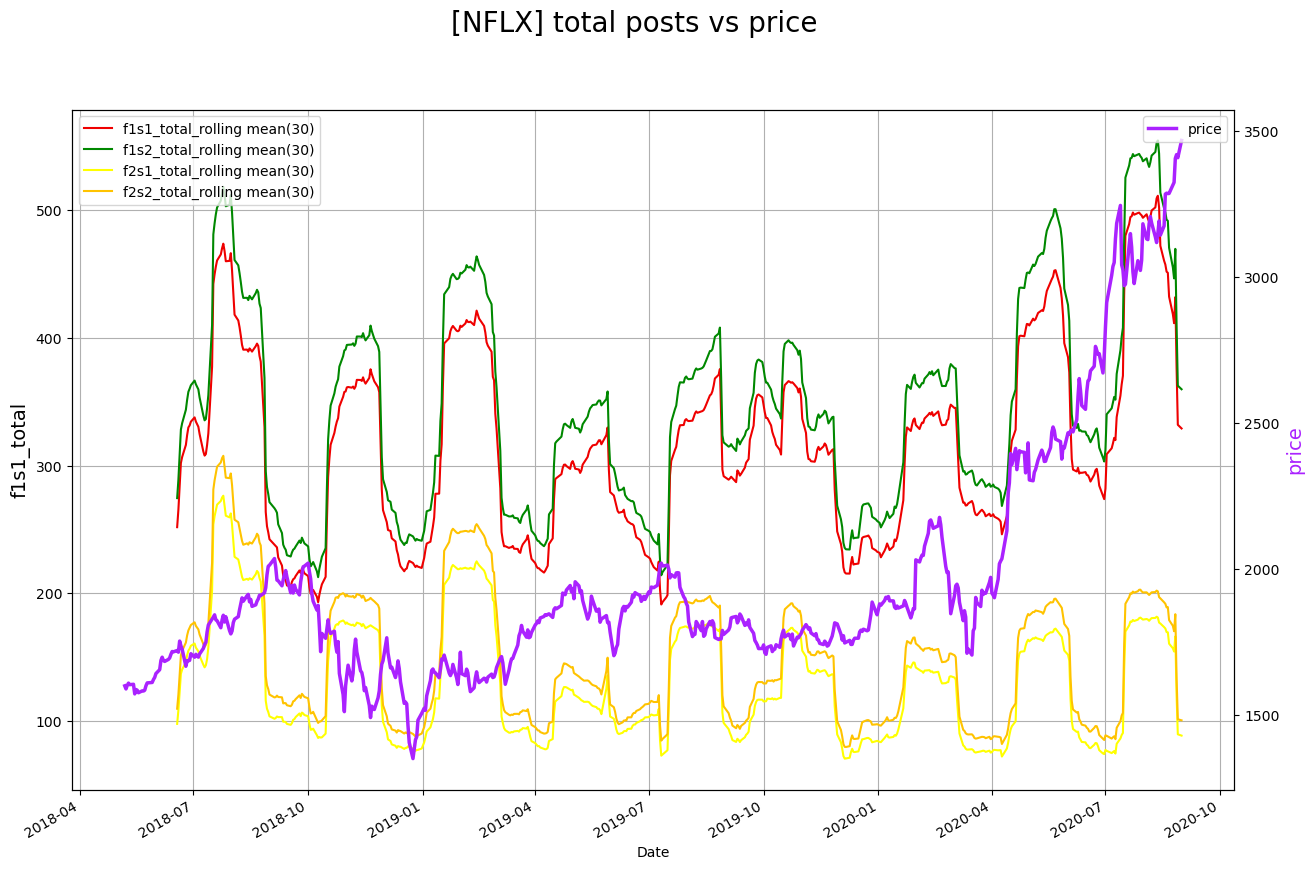
</div>

--- 

A big difference between filter 1 and filter 2 can be seen. The total amount of social media posts is significantly lower for filter 2 than for filter 1. This due to the stricter rules which filter 2 contained. Further, it can be seen that sentiment method 2 find more positive and negative post than sentiment 1. This is probably due to the extra custom rules, which cause the texts to be less likely to be categorised as neutral.

**I will only be using sentiment method 2, as this is more focussed on financial texts than the sentiment 1 method.**

## The correct sentiment measure <a class="anchor" id="bullet2"></a>

Although different data filters and sentiment measuring methods are mentioned, this does not solve the problem of how sentiment needs to be measured. Do I take the total amount of positive posts as a proxy of sentiment? Or do I use the ratio of positive and negative posts. Or do I subtract the negative posts from the positive posts and divide that figure by the total amount of posts?

It is clear that there is no clear winner here. I propose that sentiment should be measure in two parts. The first part should contain the `relative volume` of the social media posts, as large volumes are more likely to be noticable. Part 1 will thus act as a way to strengen or weaken the total sentiment score of the day, by comparing the volume of that day with the average volume of the last 7 days. The second part of the measure should contain the actual `sentiment`. Is it positive or negative? It should also capture the severity of the sentiment. 


**Part 1**
The first part is the easier one of the two parts to measure. With the sentiment tools all returning either a positive, negative or neutral label, I decide that I will solely be focussing on the positive and negative posts. This means that these are also the posts that will be taken into considerations when looking at volume. The volume will be measured by counting the total of positive and negative posts for a given day. This daily total will then be divided by the average total posts of the last 7 days.

- $\text{Relative volume}_{t0} = \frac{\text{Total positive posts}_{t0}+\text{Total negative posts}_{t0}}{Rolling mean 30(\text{Total positive posts}_{t0}+\text{Total negative posts}_{t0})}$

**Part 2**
The second part is harded, as it is unclear what the best way to measure sentiment is. To tackle this problem, I will calculate the sentiment in different ways.
- Method 1: positive / negative
- Method 2: (positive - negative) / (positive + negative)
- Method 3: Daily mean of compound sentiment score, counting only posts categorised as positive or negative


In [60]:
def calc_sent_measures(return_df):
    # Get results dataframe
    sentiment_measures = count_posts(return_df)

    # Only keep sentiment 2 results
    sentiment_measures = sentiment_measures.loc[:, sentiment_measures.columns.str.contains('f1s2|f2s2|date')]
    
    # Method 1 - ratio
    sentiment_measures['[f1s2]method_1'] = sentiment_measures['[f1s2]pos'] / sentiment_measures['[f1s2]total']
    sentiment_measures['[f2s2]method_1'] = sentiment_measures['[f2s2]pos'] / sentiment_measures['[f2s2]total']

    # Method 2 - discontinued as it is the same as method 1
    #     sentiment_measures['[f1s2]method_2'] = (sentiment_measures['[f1s2]pos'] - sentiment_measures['[f1s2]neg']) / sentiment_measures['[f1s2]total']
    #     sentiment_measures['[f2s2]method_2'] = (sentiment_measures['[f2s2]pos'] - sentiment_measures['[f2s2]neg']) / sentiment_measures['[f2s2]total']

    # Method 3
    to_merge = return_df[(return_df['filter_1'] == True) & ((return_df['s1_pos'] == 1) | (return_df['s1_neg'] == 1))][['date', 'compound_sent_2']].groupby('date').mean().rename(columns={'compound_sent_2': '[f1s2]method_3'})
    sentiment_measures = sentiment_measures.merge(to_merge, how='left', left_on='date', right_on='date')
    to_merge = return_df[(return_df['filter_2'] == True) & ((return_df['s1_pos'] == 1) | (return_df['s1_neg'] == 1))][['date', 'compound_sent_2']].groupby('date').mean().rename(columns={'compound_sent_2': '[f2s2]method_3'})

    sentiment_measures = sentiment_measures.merge(to_merge, how='left', left_on='date', right_on='date')
    return sentiment_measures

sentiment_measures = calc_sent_measures(return_df)

### Sentiment measure correlation <a class="anchor" id="sub-bullet2.1"></a>

Next, I merge the TAQ and Robintrack stock performance with the `sentiment_measures` performance. This allows for beginning exploration of relations between social media sentiment and stock trading statistics.

In [8]:
# This functions merges the previously created filtered TAQ data with the sentiment measures.
def merge_financial_data(ticker, sentiment_measures):
    
    path = os.path.join(r"E:\Users\Christiaan\Large_Files\Thesis\robintrack_taq", f"{ticker}.csv")
    df_fin = pd.read_csv(path)

    sentiment_measures['date'] = pd.to_datetime(sentiment_measures['date'])
    df_fin['date'] = pd.to_datetime(df_fin['date'])
    df_fin = df_fin.merge(sentiment_measures, how='left', left_on='date', right_on='date')
    return df_fin


In [9]:
def find_corr(ticker, rolling_period=1):
    rolling_period = rolling_period
    sentiment_measures = calc_sent_measures(return_df)

    df_fin = merge_financial_data(ticker, sentiment_measures)
    
    df_fin[['[f1s2]method_1', '[f2s2]method_1', '[f1s2]method_2','[f2s2]method_2', '[f1s2]method_3', '[f2s2]method_3']] = df_fin[['[f1s2]method_1', '[f2s2]method_1', '[f1s2]method_2','[f2s2]method_2', '[f1s2]method_3', '[f2s2]method_3']].rolling(rolling_period).mean()
    df_fin.dropna(inplace=True)
    corr_results = df_fin[['[taq]price','[taq]total_vol', '[taq]total_bs','[f1s2]method_1', '[f2s2]method_1', '[f1s2]method_2','[f2s2]method_2', '[f1s2]method_3', '[f2s2]method_3']].corr()
    return corr_results
    

**Effect rolling mean on sentiment measures**

Correlation between variables changes whenever the rolling mean is taken. In this case, the correlation between price and the `sentiment_measures` increases for a 7, 30, 90 and 180 day rolling window.

Another observation, is that `method_1` and `method_2` are similar. 

In [12]:
find_corr("AMZN", rolling_period=1)[['[taq]price', '[taq]total_vol', '[taq]total_bs']]

,[taq]price,[taq]total_vol,[taq]total_bs
[taq]price,1.000000,-0.230208,0.145053
[taq]total_vol,-0.230208,1.000000,0.839161
[taq]total_bs,0.145053,0.839161,1.000000
[f1s2]method_1,0.314755,-0.210937,-0.131268
[f2s2]method_1,0.258933,-0.110673,-0.020418
[f1s2]method_2,0.314755,-0.210937,-0.131268
[f2s2]method_2,0.258933,-0.110673,-0.020418
[f1s2]method_3,0.311370,-0.187416,-0.112691
[f2s2]method_3,0.231589,-0.089817,-0.013180


In [13]:
find_corr("AMZN", rolling_period=7)[['[taq]price', '[taq]total_vol', '[taq]total_bs']]

,[taq]price,[taq]total_vol,[taq]total_bs
[taq]price,1.000000,-0.237643,0.138583
[taq]total_vol,-0.237643,1.000000,0.838484
[taq]total_bs,0.138583,0.838484,1.000000
[f1s2]method_1,0.497143,-0.222525,-0.094657
[f2s2]method_1,0.461126,-0.099126,0.069285
[f1s2]method_2,0.497143,-0.222525,-0.094657
[f2s2]method_2,0.461126,-0.099126,0.069285
[f1s2]method_3,0.498687,-0.210355,-0.094803
[f2s2]method_3,0.423212,-0.102582,0.040165


In [14]:
find_corr("AMZN", rolling_period=30)[['[taq]price', '[taq]total_vol', '[taq]total_bs']]

,[taq]price,[taq]total_vol,[taq]total_bs
[taq]price,1.000000,-0.264231,0.113620
[taq]total_vol,-0.264231,1.000000,0.836557
[taq]total_bs,0.113620,0.836557,1.000000
[f1s2]method_1,0.610275,-0.165905,0.018587
[f2s2]method_1,0.565973,0.034872,0.293207
[f1s2]method_2,0.610275,-0.165905,0.018587
[f2s2]method_2,0.565973,0.034872,0.293207
[f1s2]method_3,0.640552,-0.110570,0.072524
[f2s2]method_3,0.569220,0.025910,0.280192


In [15]:
find_corr("AMZN", rolling_period=90)[['[taq]price', '[taq]total_vol', '[taq]total_bs']]

,[taq]price,[taq]total_vol,[taq]total_bs
[taq]price,1.000000,-0.275631,0.101047
[taq]total_vol,-0.275631,1.000000,0.838758
[taq]total_bs,0.101047,0.838758,1.000000
[f1s2]method_1,0.579541,-0.052211,0.103174
[f2s2]method_1,0.629605,0.214056,0.426141
[f1s2]method_2,0.579541,-0.052211,0.103174
[f2s2]method_2,0.629605,0.214056,0.426141
[f1s2]method_3,0.656702,0.074774,0.242587
[f2s2]method_3,0.644474,0.215039,0.440812


In [16]:
find_corr("AMZN", rolling_period=180)[['[taq]price', '[taq]total_vol', '[taq]total_bs']]

,[taq]price,[taq]total_vol,[taq]total_bs
[taq]price,1.000000,-0.027569,0.346158
[taq]total_vol,-0.027569,1.000000,0.815447
[taq]total_bs,0.346158,0.815447,1.000000
[f1s2]method_1,0.460270,-0.163042,-0.082330
[f2s2]method_1,0.710174,0.114653,0.209142
[f1s2]method_2,0.460270,-0.163042,-0.082330
[f2s2]method_2,0.710174,0.114653,0.209142
[f1s2]method_3,0.555284,0.041901,0.046500
[f2s2]method_3,0.710438,0.156592,0.262487


**Effect rolling mean on [taq]total_vol and [taq]total_bs**

Just like in the part above, using a rolling mean on `[taq]total_vol` and `[taq]total_bs` increases the correlation between these variables and the sentiment variables. The effect is not as strong however and is mostly visisble with `[taq]total_bs`.

In [17]:
def find_corr(ticker, rolling_period=1):
    rolling_period = rolling_period
    sentiment_measures = calc_sent_measures(return_df)

    df_fin = merge_financial_data(ticker, sentiment_measures)
    # Now also taking rolling mean of [taq]total_vol and [taq]total_bs
    df_fin[['[taq]total_vol', '[taq]total_bs', '[f1s2]method_1', '[f2s2]method_1', '[f1s2]method_2','[f2s2]method_2', '[f1s2]method_3', '[f2s2]method_3']] = df_fin[['[taq]total_vol', '[taq]total_bs', '[f1s2]method_1', '[f2s2]method_1', '[f1s2]method_2','[f2s2]method_2', '[f1s2]method_3', '[f2s2]method_3']].rolling(rolling_period).mean()
    df_fin.dropna(inplace=True)
    corr_results = df_fin[['[taq]price','[taq]total_vol', '[taq]total_bs','[f1s2]method_1', '[f2s2]method_1', '[f1s2]method_2','[f2s2]method_2', '[f1s2]method_3', '[f2s2]method_3']].corr()
    return corr_results
    

In [18]:
find_corr("AMZN", rolling_period=90)[['[taq]price', '[taq]total_vol', '[taq]total_bs']]

,[taq]price,[taq]total_vol,[taq]total_bs
[taq]price,1.000000,-0.343365,0.249288
[taq]total_vol,-0.343365,1.000000,0.759096
[taq]total_bs,0.249288,0.759096,1.000000
[f1s2]method_1,0.579541,-0.213885,0.038719
[f2s2]method_1,0.629605,0.124040,0.562304
[f1s2]method_2,0.579541,-0.213885,0.038719
[f2s2]method_2,0.629605,0.124040,0.562304
[f1s2]method_3,0.656702,0.044720,0.358249
[f2s2]method_3,0.644474,0.126778,0.581770


### MinMax scaling graph sentiment measurements <a class="anchor" id="sub-bullet2.2"></a>

The graph below shows a MinMax scaled graph of the sentiment measures. Only 4 lines can be seen. This is due to same finding as earlier, that method 1 and 2 are similar for both f1s2 and f2s2.

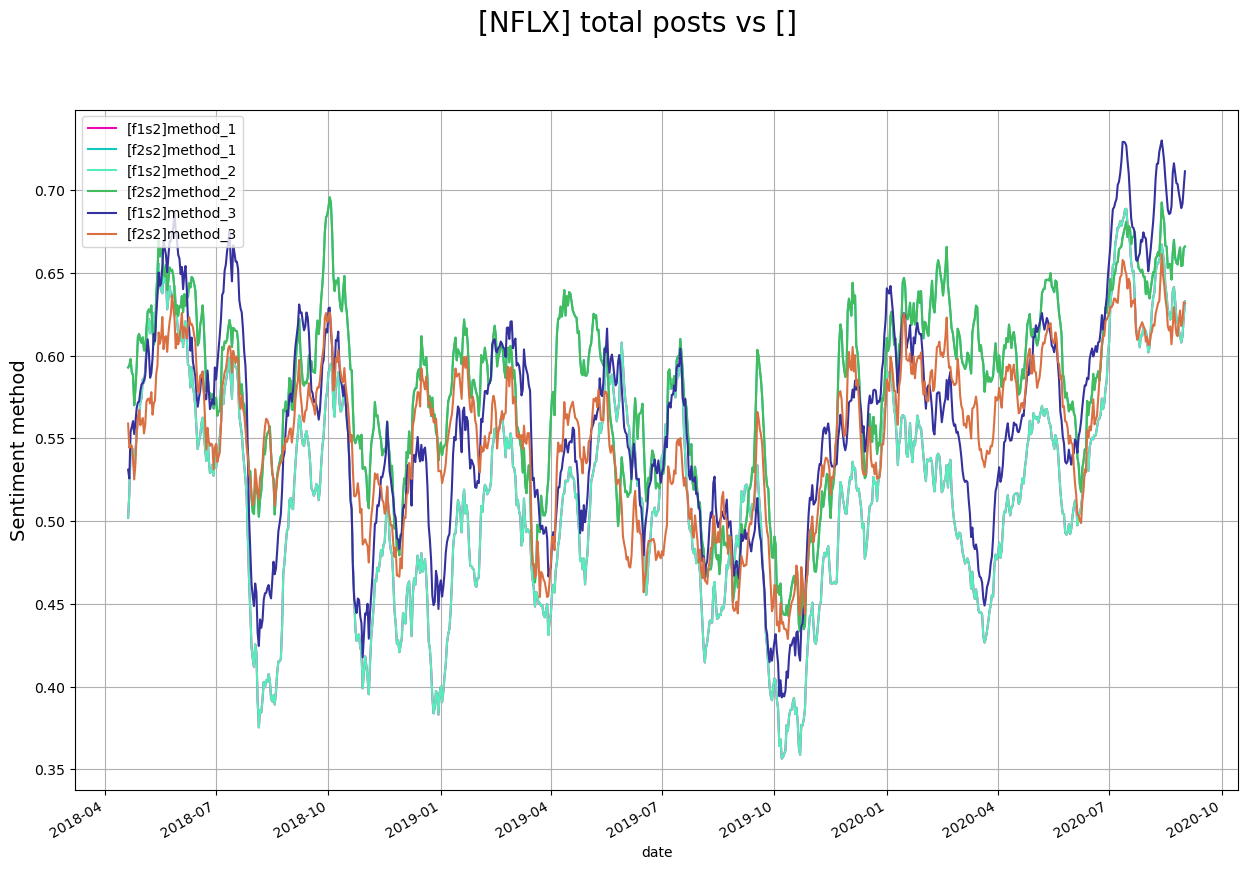

In [151]:
from sklearn.preprocessing import MinMaxScaler
import random

scaler = MinMaxScaler()

def random_colour():
    colour = "#%06x" % random.randint(0, 0xFFFFFF)
    return colour

def plot_graph(df, ticker, y1, y2=[], x='date', y1_label="", y2_label="", rolling=1):
    df.loc[:, df.columns != 'date'] = pd.DataFrame(scaler.fit_transform(df.loc[:, df.columns != 'date']), columns=df.loc[:, df.columns != 'date'].columns)

    fig, ax1 = plt.subplots(figsize=(15, 10))
    
    if len(y2) > 0:
        ax2 = ax1.twinx()
        ax2.set_ylabel(''.join(y2), fontsize=14)
        ax2.tick_params(axis="y")
        ax2.legend(loc = "upper right")
        
    for y in y1: 
        ax1.plot(df[x], df[y].rolling(rolling).mean(), label=y, color=random_colour(), lw=1.5) 
        
    for y in y2: 
        ax2.plot(df[x], df[y].rolling(rolling).mean(), label=y, color=random_colour(), lw=1.5) 
    
    
    ax1.set_xlabel(x)
    ax1.set_ylabel(y1_label, fontsize=14)
    ax1.tick_params(axis="y")
    ax1.grid()
    

    
    ax1.legend(loc = "upper left")
    fig.suptitle(f"[{ticker}] total posts vs {y2}", fontsize=20)
    fig.autofmt_xdate()
    plt.show()


plot_graph(sentiment_measures, 'NFLX', y1=['[f1s2]method_1', '[f2s2]method_1', '[f1s2]method_2',
       '[f2s2]method_2', '[f1s2]method_3', '[f2s2]method_3'], y1_label="Sentiment method", rolling=20)


## Looping all stock csv's <a class="anchor" id="bullet3"></a>

In [44]:
def loop_tickers(func):
    '''Decorator that loops all (ticker) files in the directory.'''
  
    def wrap(*args, **kwargs):
        if 'file_dir' in kwargs:
            for filename in os.listdir(filedir):
                csv_path = os.path.join(filedir, filename)
                kwargs['ticker'] = csv_path.split("\\")[-1].split(".")[0]
                # checking if it is a file
                if os.path.isfile(csv_path):
                    
                    message = f"""Now executing function {func.__name__} for [{filename}], variables:
                    - csv_path: [{csv_path}]
                    - kwargs: [{kwargs}])"""
                    print(message)

                    result = func(csv_path=csv_path, *args, **kwargs)
                    
        else:
            raise ValueError("Wrapper can not loop, as no file directory given. Please specify which folder needs to be looped by setting 'file_dir' variable.") 
        
        
        
        return result
    return wrap

In [65]:
@loop_tickers
def calculate_sentiment_ticker(*args, **kwargs):
    # Setting up save location
    ticker = kwargs['ticker']
    save_dir = r"E:\Users\Christiaan\Large_Files\Thesis\Twitter\sentiment\VADER"
    save_path = os.path.join(save_dir, f"{ticker}.csv").replace('\\', '/')
    
    # Check if file already exists and skip sentiment calculation if file exists
    if os.path.isfile(save_path):
        print(f"File exists: [{save_path}]")
        
    
    else:  
        csv_path = kwargs['csv_path']

        # Read csv
        df = pd.read_csv(csv_path)

        # Filter and clean data. Also perform VADER sentiment scoring.
        return_df = clean_data(df, ticker)

        # Count the posts for each filter 
        results_df = count_posts(return_df)

        # Calculate sentiment scores for each method
        sentiment_measures = calc_sent_measures(return_df)
        
        # Saving the dataframe
        sentiment_measures.to_csv(save_path, encoding='utf-8', index=False)
    

filedir = r"E:\Users\Christiaan\Large_Files\Thesis\Twitter\merged"
calculate_sentiment_ticker(file_dir= filedir)

Now executing function calculate_sentiment_ticker for [AAPL.csv], variables:
                    - csv_path: [E:\Users\Christiaan\Large_Files\Thesis\Twitter\merged\AAPL.csv]
                    - kwargs: [{'file_dir': 'E:\\Users\\Christiaan\\Large_Files\\Thesis\\Twitter\\merged', 'ticker': 'AAPL'}])
[AAPL] Done cleaning after --- 31.45575261116028 seconds ---
[AAPL] Done filtering after --- 38.26599884033203 seconds ---
[AAPL] Done calculating sentiment after --- 285.65811491012573 seconds ---
Now executing function calculate_sentiment_ticker for [AMD.csv], variables:
                    - csv_path: [E:\Users\Christiaan\Large_Files\Thesis\Twitter\merged\AMD.csv]
                    - kwargs: [{'file_dir': 'E:\\Users\\Christiaan\\Large_Files\\Thesis\\Twitter\\merged', 'ticker': 'AMD'}])
[AMD] Done cleaning after --- 9.787404537200928 seconds ---
[AMD] Done filtering after --- 11.916067361831665 seconds ---
[AMD] Done calculating sentiment after --- 83.56370830535889 seconds ---
Now exec

[NVDA] Done cleaning after --- 7.763524532318115 seconds ---
[NVDA] Done filtering after --- 9.464530944824219 seconds ---
[NVDA] Done calculating sentiment after --- 68.21969223022461 seconds ---
Now executing function calculate_sentiment_ticker for [SBUX.csv], variables:
                    - csv_path: [E:\Users\Christiaan\Large_Files\Thesis\Twitter\merged\SBUX.csv]
                    - kwargs: [{'file_dir': 'E:\\Users\\Christiaan\\Large_Files\\Thesis\\Twitter\\merged', 'ticker': 'SBUX'}])
[SBUX] Done cleaning after --- 2.6504738330841064 seconds ---
[SBUX] Done filtering after --- 3.2991137504577637 seconds ---
[SBUX] Done calculating sentiment after --- 23.170656204223633 seconds ---
Now executing function calculate_sentiment_ticker for [SHOP.csv], variables:
                    - csv_path: [E:\Users\Christiaan\Large_Files\Thesis\Twitter\merged\SHOP.csv]
                    - kwargs: [{'file_dir': 'E:\\Users\\Christiaan\\Large_Files\\Thesis\\Twitter\\merged', 'ticker': 'SHOP'}])
[

## ToDo <a class="anchor" id="ToDo"></a>

[Go back up](#top)

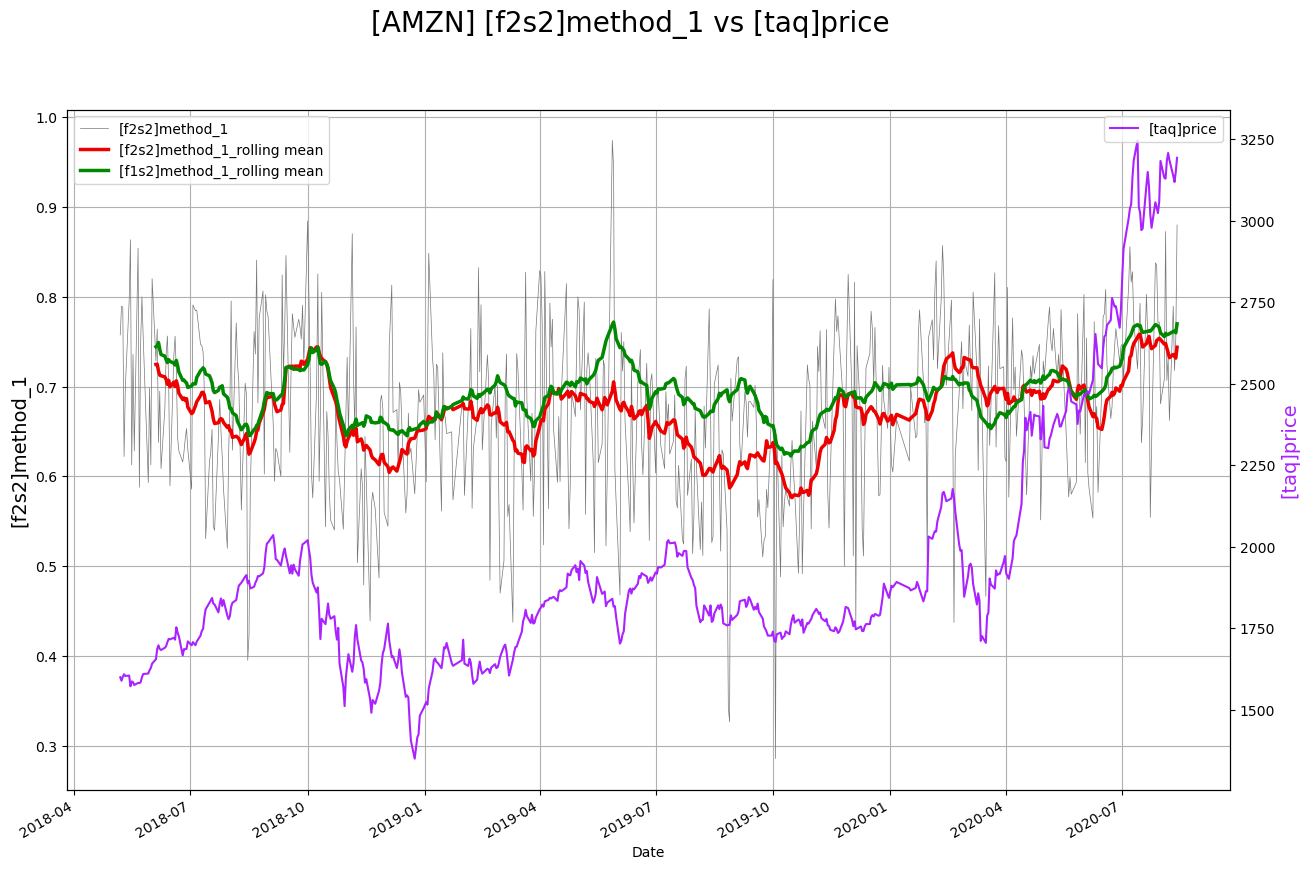

In [26]:
def plot_graph(df, ticker, x='date', y1='performance_1', y2='[taq]price'):
    
    fig, ax1 = plt.subplots(figsize=(15, 10))
    ax2 = ax1.twinx()

    colour_1 = "#777777"
    colour_2 = "#ef0000"
    colour_3 = "#008800"
    colour_4 = "#aa22ff"
    colour_5 = "#ffff00"
    colour_6 = "#FFC300"
    
    ax1.plot(df[x], df[y1], label=y1, color=colour_1, lw=0.5) 
    ax1.plot(df[x], df[y1].rolling(20).mean(), label=f"{y1}_rolling mean", color=colour_2, lw=2.5)
    
    column = '[f1s2]method_1'
    ax1.plot(df[x], df[column].rolling(20).mean(), label=f"{column}_rolling mean", color=colour_3, lw=2.5) 

    
    
#     ax2.plot(df[x], df['f2s2_pos'].rolling(20).mean(), label=y2, color=colour_3, lw=1.5)
    ax2.plot(df[x], df[y2], label=y2, color=colour_4, lw=1.5)

    # This line is a rolling average, useful for getting a better view of the data
    
    ax1.set_xlabel("Date")
    ax1.set_ylabel(y1, fontsize=14)
    ax1.tick_params(axis="y")
    ax1.grid()

    ax2.set_ylabel(y2, color=colour_4, fontsize=14)
    ax2.tick_params(axis="y")
    
    ax1.legend(loc = "upper left")
    ax2.legend(loc = "upper right")
    fig.suptitle(f"[{ticker}] {y1} vs {y2}", fontsize=20)
    fig.autofmt_xdate()
    plt.show()

ticker = "AMZN"
df_fin = merge_financial_data(ticker, sentiment_measures)
plot_graph(df_fin, ticker, y1='[f2s2]method_1', y2='[taq]price')

In [90]:
# Check if sentiment corresponds to pos, neg or neu sentiment for compound_sent_1
return_df['s1_pos'] = np.where(return_df['compound_sent_1'] >= 0.05, 1, 0)
return_df['s1_neg'] = np.where(return_df['compound_sent_1'] <= -0.05, 1, 0)
return_df['s1_neu'] = np.where((return_df['compound_sent_1'] > -0.05) & (return_df['compound_sent_1'] < 0.05), 1, 0)

# Check if sentiment corresponds to pos, neg or neu sentiment for compound_sent_2
return_df['s2_pos'] = np.where(return_df['compound_sent_2'] >= 0.05, 1, 0)
return_df['s2_neg'] = np.where(return_df['compound_sent_2'] <= -0.05, 1, 0)
return_df['s2_neu'] = np.where((return_df['compound_sent_2'] > -0.05) & (return_df['compound_sent_1'] < 0.05), 1, 0)

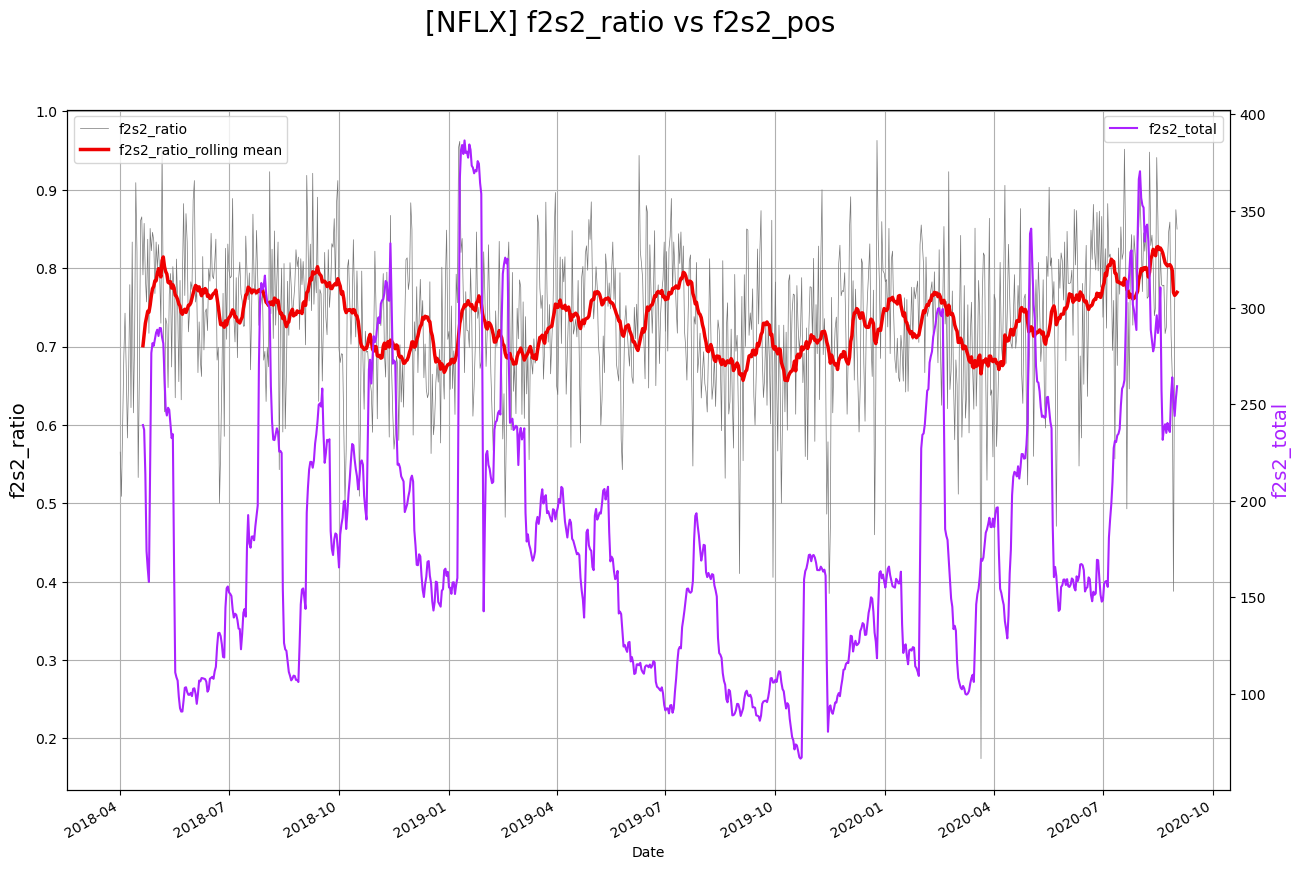

In [125]:
def plot_graph(df, ticker, x='date', y1='performance_1', y2='[taq]price'):
    
    fig, ax1 = plt.subplots(figsize=(15, 10))
    ax2 = ax1.twinx()

    colour_1 = "#777777"
    colour_2 = "#ef0000"
    colour_3 = "#008800"
    colour_4 = "#aa22ff"
    
    ax1.plot(df[x], df[y1], label=y1, color=colour_1, lw=0.5) 
#     ax2.plot(df[x], df['f2s2_pos'].rolling(20).mean(), label=y2, color=colour_3, lw=1.5)
    ax2.plot(df[x], df['f2s2_total'].rolling(20).mean(), label='f2s2_total', color=colour_4, lw=1.5)

    # This line is a rolling average, useful for getting a better view of the data
    ax1.plot(df[x], df[y1].rolling(20).mean(), label=f"{y1}_rolling mean", color=colour_2, lw=2.5)
    
    ax1.set_xlabel("Date")
    ax1.set_ylabel(y1, fontsize=14)
    ax1.tick_params(axis="y")
    ax1.grid()

    ax2.set_ylabel("f2s2_total", color=colour_4, fontsize=14)
    ax2.tick_params(axis="y")
    
    ax1.legend(loc = "upper left")
    ax2.legend(loc = "upper right")
    fig.suptitle(f"[{ticker}] {y1} vs {y2}", fontsize=20)
    fig.autofmt_xdate()
    plt.show()

plot_graph(results_df, 'NFLX', y1='f2s2_ratio', y2='f2s2_pos')

In [16]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
SIA = SentimentIntensityAnalyzer()

text = "I am very bearish target $290.55"
# text = "$NFLX wants $300 . Give it some momentum or news and we 🚀🚀"
# text = "Netflix $NFLX Upgraded to Buy by Zacks Investment Research"
# text = "$tsla 🚀🚀🚀"
text = "📈📉"
text = "$NFLX is my hottest playfor April 📈"
text = "Netflix will exist for a long time as a company. It's valuation however is madness. It's too expensive and it's not a viable investment in the long term. $NFLX  #NetflixEurope #StockMarket #stocks #investing"
result = SIA.polarity_scores(text)
print(result)

new_words = {}

# Adding custom postive words
positive_words = {
    'buy': 2.0,
    'buying': 2.0,
    'bullish': 2.0,
    'long': 1.0,
    'call': 1.0,
    'calls': 1.0,
    'rocket': 3.0,        # Added for 'rocket' emoji 🚀
    'increasing': 2.0,     # Added for 'chart increasing' emoji 📈
    'to the moon': 2.5,
    "undervalued": 2.0
}
# Adding custom negative words
negative_words = {
    'decreasing': -2.0,   # Added for 'chart increasing' emoji 📉
    'sell': -2.0,
    'selling': -2.0,
    'bearish': -2.0,
    'put': -1,
    'puts': -1,
    'short': -1.0,
    'shorting': -1.5,
    "overvalued": -2.0,
    'expensive': -1.5
}


# Adding positive and negative words to new_worddictionary
new_words.update(positive_words)
new_words.update(negative_words)

SIA = SentimentIntensityAnalyzer()
SIA.lexicon.update(new_words)


result = SIA.polarity_scores(text)
print(result)

{'neg': 0.083, 'neu': 0.917, 'pos': 0.0, 'compound': -0.4404}
{'neg': 0.141, 'neu': 0.755, 'pos': 0.104, 'compound': -0.34}


In [76]:
print(str("🚀"))

🚀


<AxesSubplot:>

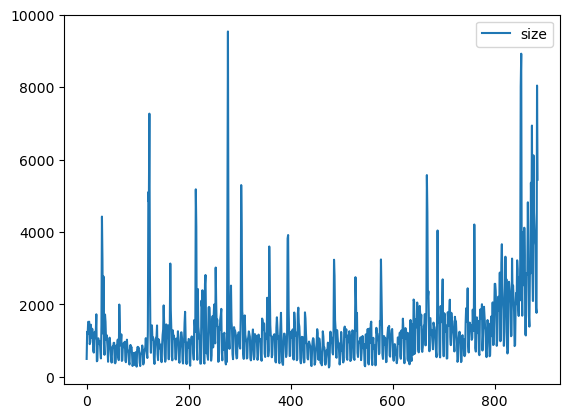

In [31]:
df.groupby('date', as_index=False).size().plot()

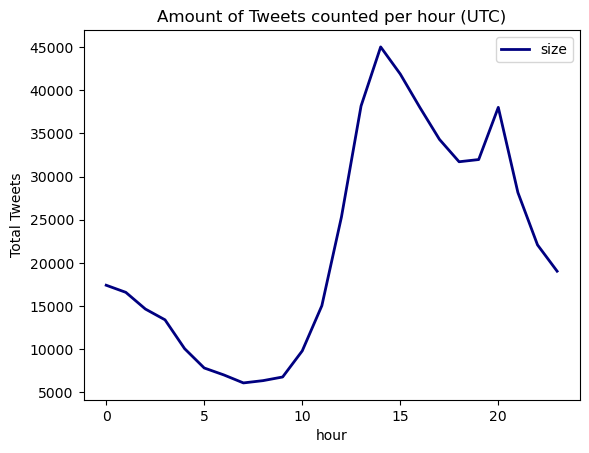

In [28]:
path = r"E:\Users\Christiaan\Large_Files\Thesis\Twitter\merged\NFLX.csv"
df = pd.read_csv(path)

day_activity = df.groupby('hour', as_index=False).size()

# Plot results
ax = day_activity.plot(x="hour", y=["size"], lw=2, colormap='jet', markersize=10, title='Amount of Tweets counted per hour (UTC)')
ax.set(xlabel="hour", ylabel="Total Tweets")
plt.show()

## Graphs

Checking when Twitter activity is highest, it seems that Twitter activity is highest at the 14:00 mark, and lowest at 07:00.

Apple (AAPL) shows the following results
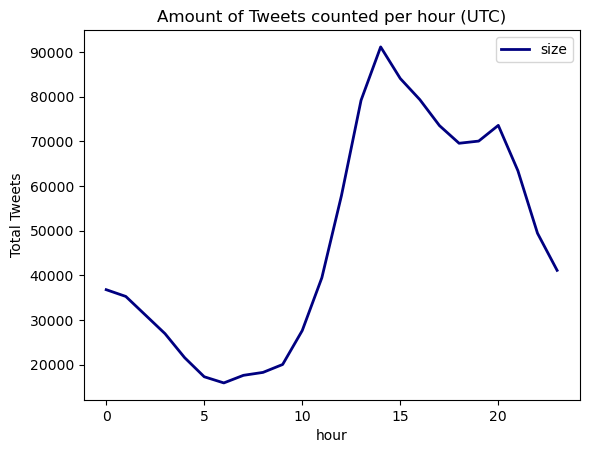

Netflix (NFLX) shows similar results
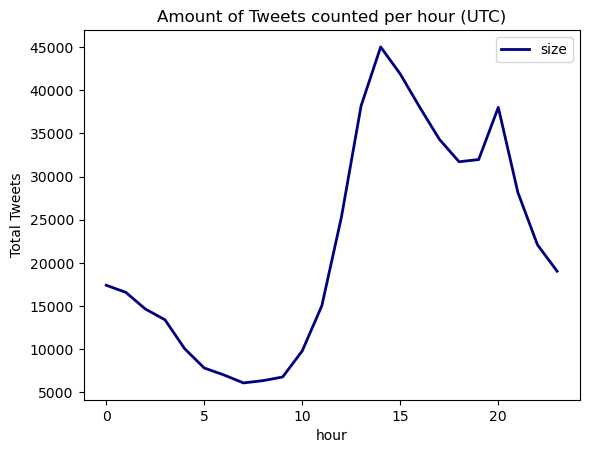

# Vault <a class="anchor" id="vault"></a>

 [Go back up](#top)

In [24]:
import torch

In [25]:
print(torch.__version__)

1.13.1+cu116


In [21]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


ImportError: 
BertForSequenceClassification requires the PyTorch library but it was not found in your environment. Checkout the instructions on the
installation page: https://pytorch.org/get-started/locally/ and follow the ones that match your environment.
Please note that you may need to restart your runtime after installation.


In [ ]:
nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer, device=0)
sentence_list = ['With a massive increase in profitability, the stock gains of Tesla were not unexpected']
results = nlp(sentence_list)
print(results)  #LABEL_0: neutral; LABEL_1: positive; LABEL_2: negative

In [27]:
import torch
for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_properties(i).name)

NVIDIA GeForce GTX 750 Ti


In [15]:
import time

def calculate_runtime(function):
    """
    A wrapper function that calculates the runtime of the specified function.
    """
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = function(*args, **kwargs)
        end_time = time.time()
        print(f"Runtime for {function.__name__}: {end_time - start_time} seconds")
        return result
    return wrapper

In [30]:
@calculate_runtime
def calc_rows(size):
    for row in range(size):
        calc_sent_finbert(size)
def calc_sent_finbert(row):
    nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer, device=0)

    sentence_list = return_df.iloc[row:row+1]['text'].tolist()
    results = nlp(sentence_list)
    # print(results)  #LABEL_0: neutral; LABEL_1: positive; LABEL_2: negative

size_list = [10, 100, 1000, 10000]

for size in size_list:
    print(f"Calcing sent for [{size}] sentences")
    calc_rows(size)





Calcing sent for [10] sentences
Runtime for calc_rows: 0.3248138427734375 seconds
Calcing sent for [100] sentences
Runtime for calc_rows: 1.7200281620025635 seconds
Calcing sent for [1000] sentences
Runtime for calc_rows: 14.51870059967041 seconds
Calcing sent for [10000] sentences
Runtime for calc_rows: 366.51324224472046 seconds


In [37]:
@calculate_runtime
def calc_sent_finbert(size):
    nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer, device=0)

    sentence_list = return_df.iloc[:size]['text'].tolist()
    results = nlp(sentence_list)
    # print(results)  #LABEL_0: neutral; LABEL_1: positive; LABEL_2: negative

size_list = [10, 100, 1000, 10000, 20000]

for size in size_list:
    print(f"Calcing sent for [{size}] sentences")
    calc_sent_finbert(size)





Calcing sent for [10] sentences
Runtime for calc_sent_finbert: 0.14393019676208496 seconds
Calcing sent for [100] sentences
Runtime for calc_sent_finbert: 1.7862770557403564 seconds
Calcing sent for [1000] sentences
Runtime for calc_sent_finbert: 17.48098874092102 seconds
Calcing sent for [10000] sentences
Runtime for calc_sent_finbert: 172.90117263793945 seconds
Calcing sent for [20000] sentences
Runtime for calc_sent_finbert: 359.7904999256134 seconds


In [ ]:
# df.groupby('date').agg(
#         {'price': 'mean', 'size': 'sum', 'buy': 'sum', 'sell': 'sum', 'buy_vol': 'sum', 'sell_vol': 'sum'})
#           .round(2)
#           .rename(columns={'size': 'total_vol'})